In [143]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import pickle
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import copy
import pickle5 as pickle

RANDOM_SEED = 56
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
root_path = 'gdrive/My Drive/deep/'  #change dir to your project folder

In [4]:
# Load data
df0 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-0_cleaned.pickle", "rb" ) )
df1 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-1_cleaned.pickle", "rb" ) )

In [237]:
df = df0.append(df1, ignore_index=True)

In [1]:
!pip install -qq arff2pandas

In [31]:
!pip install -q -U watermark

In [3]:
!pip install -qq -U pandas

     |████████████████████████████████| 11.3 MB 5.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [4]:
!pip install pickle5

     |████████████████████████████████| 132 kB 5.3 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219335 sha256=daaf5dcdbb2936ec2ec53590fca2003f4bbc24bd8db2dd485a0469d0a255569d
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [10]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.3.4
torch      : 1.9.0+cu111
arff2pandas: 1.0.1



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [122]:
df.head()

,IRI_mean,IRI_sequence,GM.TS_or_Distance,GM.T,GM.lat_int,GM.lon_int,GM.acc.xyz.z,GM.acc.xyz.y,GM.acc.xyz.x,GM.obd.spd_veh.value
0,4.93354,"[6.644882798499999, 5.5573473115, 7.666319952,...","[2021-04-22 01:21:54.349000+00:00, 2021-04-22 ...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, obd.spd_v...","[55.654713308383236, 55.65471373053892, 55.654...","[12.486686901197604, 12.486686532934131, 12.48...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9922, 0.992...","[-0.1172, -0.1172, -0.1172, -0.1172, -0.1211, ...","[0.1602, 0.1602, 0.1602, 0.1602, 0.1563, 0.156...","[31.04, 31.0, 30.970000000000002, 31.470000000..."
1,4.696225,"[5.5573473115, 7.666319952, 4.1605364705, 5.35...","[2021-04-22 01:21:55.068000+00:00, 2021-04-22 ...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654781462897525, 55.65478160070671, 55.654...","[12.48662899293286, 12.486628876325089, 12.486...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9727, 0.972...","[-0.0898, -0.0898, -0.0898, -0.0898, -0.0898, ...","[0.1406, 0.1406, 0.1406, 0.1406, 0.1406, 0.140...","[29.52, 29.48, 29.42, 29.400000000000002, 29.3..."
2,4.699145,"[7.666319952, 4.1605364705, 5.359907053000001,...","[2021-04-22 01:21:56.327000+00:00, 2021-04-22 ...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654862308917195, 55.65486260509554, 55.654...","[12.486560579617835, 12.486560331210192, 12.48...","[1.0391, 1.0391, 1.0391, 1.0391, 1.0391, 1.015...","[0.0273, 0.0273, 0.0273, 0.0273, 0.0273, 0.011...","[0.1523, 0.1523, 0.1523, 0.1523, 0.1523, 0.160...","[30.080000000000002, 30.14, 30.2, 30.23, 29.54..."
3,4.397566,"[4.1605364705, 5.359907053000001, 4.5512844555...","[2021-04-22 01:21:57.983000+00:00, 2021-04-22 ...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654942544169614, 55.65494265017668, 55.654...","[12.486492964664311, 12.486492879858657, 12.48...","[1.0391, 1.0391, 0.9805, 0.9805, 0.9805, 0.980...","[0.1016, 0.1016, 0.0898, 0.0898, 0.0898, 0.089...","[0.2188, 0.2188, 0.1953, 0.1953, 0.1953, 0.195...","[36.910000000000004, 37.0, 37.07, 37.18, 37.25..."
4,4.400549,"[5.359907053000001, 4.5512844555, 5.8527534034...","[2021-04-22 01:21:59.120000+00:00, 2021-04-22 ...","[obd.spd_veh, acc.xyz, acc.xyz, acc.xyz, acc.x...","[55.65502238338658, 55.65502269329073, 55.6550...","[12.486424923322684, 12.486424661341852, 12.48...","[0.9492, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...","[0.0859, 0.0977, 0.0977, 0.0977, 0.0977, 0.097...","[0.1875, 0.1563, 0.1563, 0.1563, 0.1563, 0.156...","[41.2, 41.27, 41.38, 41.46, 41.53, 40.76, 41.6..."


In [8]:
!nvidia-smi

Sun Nov  7 21:52:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [267]:
df = df0.append(df1, ignore_index=True)

In [268]:
#shuffle df
df = df.sample(frac=1.0)
df.shape

(3830, 10)

In [269]:
df = df[0:20]

# Pad with initial zeroes

In [270]:
ts_max_len = max(df['GM.acc.xyz.z'].apply(len))
padded_ts = []

for index, ls in df['GM.acc.xyz.z'].items():
    padded_ts.append(np.concatenate(([0] * (ts_max_len - len(ls)), ls)))
    
s1 = pd.Series(padded_ts, index=df.index, name='GM.acc.xyz.z')

In [271]:
df['GM.acc.xyz.z'] = s1

In [272]:
iri_threshold = 5
normal_df = df['GM.acc.xyz.z'][df['IRI_mean'] <= iri_threshold]
normal_df.shape

(18,)

In [273]:
anomaly_df = df['GM.acc.xyz.z'][df['IRI_mean'] >= iri_threshold]
anomaly_df.shape

(2,)

In [274]:
anomaly_df = pd.DataFrame(anomaly_df.tolist())

In [275]:
normal_df = pd.DataFrame(normal_df.tolist())

In [276]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

# convert to tensors

In [277]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [278]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [279]:
batch_size = 2 #64

In [280]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [281]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [282]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [283]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [284]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

      print(f'train loss {loss.item()}')      

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [285]:
import datetime

In [286]:
print(datetime.datetime.now())
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=2
)
print(datetime.datetime.now())

2021-11-07 23:36:49.807099
train loss 1782.451171875
train loss 2025.518798828125
train loss 2315.296875
train loss 1621.081787109375
train loss 1954.548583984375
train loss 1940.400634765625
train loss 1672.182861328125
train loss 1639.1722412109375
train loss 1860.603271484375
train loss 2476.7607421875
train loss 1905.01025390625
train loss 2179.1123046875
train loss 5011.8466796875
train loss 2126.730712890625
train loss 2451.8876953125
Epoch 1: train loss 2197.506974283854 val loss 2049.8228759765625
train loss 1858.80078125
train loss 1671.6240234375
train loss 1964.2425537109375
train loss 1250.236328125
train loss 1809.447021484375
train loss 1924.994140625
train loss 1509.4287109375
train loss 1425.763916015625
train loss 1678.31591796875
train loss 2370.94287109375
train loss 1916.0916748046875
train loss 2154.171875
train loss 5030.52490234375
train loss 2061.869384765625
train loss 2398.5126953125
Epoch 2: train loss 2068.331119791667 val loss 1992.5444946289062
2021-11-07 

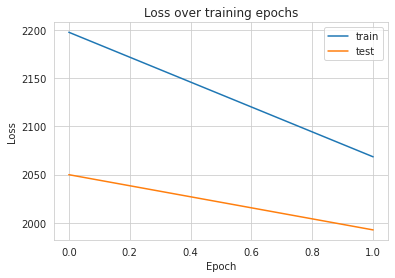

In [287]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [288]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [292]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [290]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

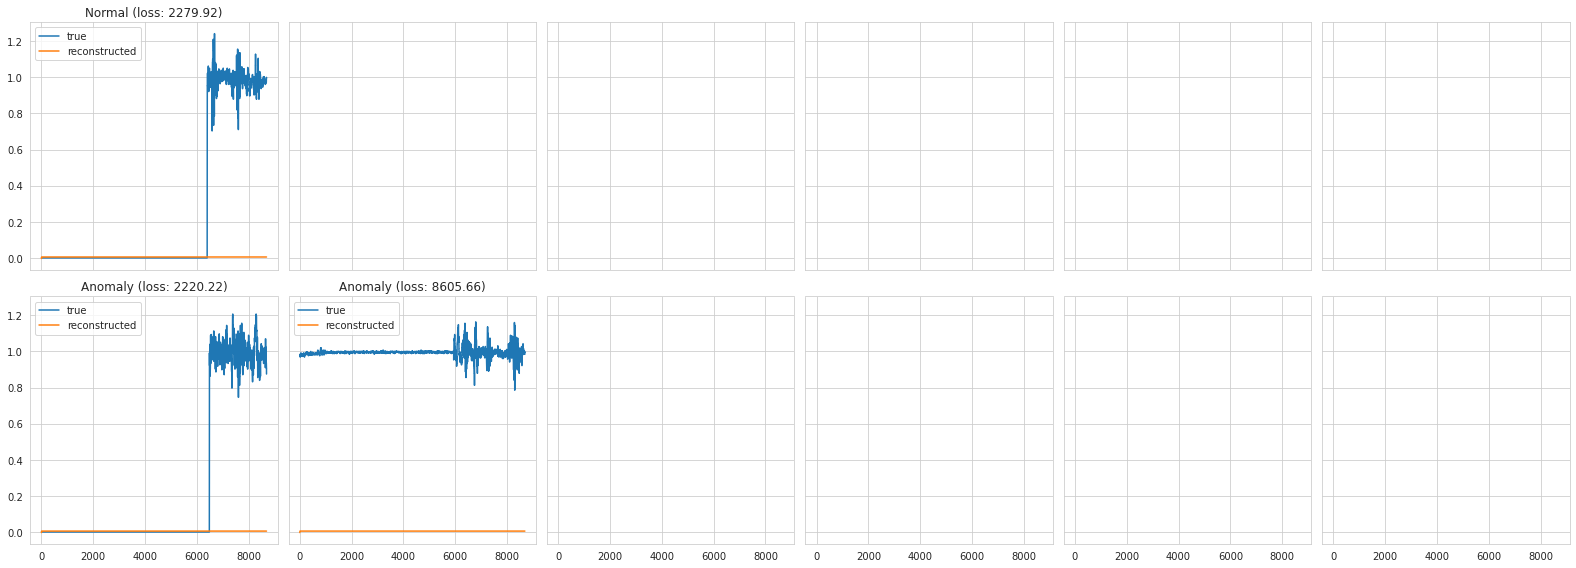

In [293]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();